# Automating creation of pre-planned routes

Let's take a look at how we can automate the creation of pre-planned routes using the **ArcGIS API for Python**. In this example, we will loosely follow the **Plan Routes for Food Inspectors** lesson plan (see below) and show how you can share the resulting routes from our analysis to **Navigator for ArcGIS**.

>### Plan Routes for Food Inspectors
>#### [Help four health officials inspect 36 restaurants in San Diego County](http://learn.arcgis.com/en/projects/plan-routes-for-food-inspectors/) (Learn ArcGIS)
>
>San Diego County includes 4,300 squares miles of Southern California. It also has 12,000 food establishments — and you, as a supervisor for the county's retail food monitoring and compliance program, have just four inspectors. In this lesson, you'll map the unannounced inspections of your food detectives in ways that spreads their stops geographically while keeping them in restaurants more and on roads less.

## Lesson Plan
- **Create layers for analysis** - Create layers by using Feature Collections and publishing CSV files as Feature Layers
- **Find the routes and stops** - Identify the most efficient routes for the inspectors to take to the restaurants
- **Share routes with inspectors** - Create URLs for inspectors to quickly open routes in Navigator for ArcGIS

---

### Create layers for analysis
First, you'll start by creating layers so you can organize 4 inspectors with the 36 restaurants they'll visit. Your inspectors will start these routes from their homes and complete their shifts at the Retail Food Monitoring Office, where they'll file reports and gather assignments for the following day.

#### Connect to GIS
Before we get started, we'll need to import the ArcGIS module to use the [ArcGIS API for Python](https://developers.arcgis.com/python/) and connect to our GIS.

In [16]:
from arcgis.gis import GIS

gis = GIS("https://arcgis.com", "navcurator_port")

Enter password: ········


#### Create a layer for the headquarters

1. Import the geocode function from the geocode module. Reverse geocode the office headquarters address, using the first result's location as the geometry for your headquarters Feature.

In [17]:
from arcgis.geocoding import geocode
from arcgis import features

headquarters_location = geocode("5500 Overland Ave San Diego California, 92123", out_sr={"wkid": 3857})[0]["location"]
headquarters_location["spatialReference"] = {"wkid": 3857}
headquarters_feature = arcgis.features.Feature(
    attributes={
        "ObjectID": 1,
        "Name": "Retail Food Monitoring Office"
    },
    geometry=headquarters_location
)

2. Create a Feature Collection from a Feature Set that contains your headquarters Feature. Create a layer from your Feature Collection and Feature Set. The analysis will use this layer so inspectors can return to the office at the end of their routes.

In [18]:
feature_set = arcgis.features.FeatureSet([headquarters_feature])
feature_collection = arcgis.features.FeatureCollection.from_featureset(feature_set)
headquarters_layer = {"layerDefinition": feature_collection.properties["layers"][0]["layerDefinition"], "featureSet": feature_set.value}

#### Create a layer for the restaurants

1. Add CSV file as an item in your GIS, or update if the item already exists.

In [19]:
restaurants_properties = {'title':'Restaurant_Inspections',
                          'tags':'UC2019',
                          'type':'CSV'}
existing_csv_items = gis.content.search('title:Restaurant_Inspections type:CSV')
if not existing_csv_items:
    restaurants_csv = gis.content.add(restaurants_properties,
                                      data='../data/Restaurants.csv',
                                      folder='UC2019')
else:
    restaurants_csv = existing_csv_items[0]
    restaurants_csv.update(restaurants_properties,
                                 data='../data/Restaurants.csv',)

2. Publish CSV item to spatially enable as a Feature Service.

In [20]:
restaurants_lyr = restaurants_csv.publish(overwrite=True)
restaurants_lyr

<Item title:"Restaurant_Inspections" type:Feature Layer Collection owner:navcurator_port>

#### Create a layer for the inspectors' homes

1. Add CSV file as an item in your GIS, or update if the item already exists.

In [21]:
homes_properties = {'title':'Inspector_Homes',
                    'tags':'UC2019',
                    'type':'CSV'}
existing_csv_items = gis.content.search('title:Inspector_Homes type:CSV')
if not existing_csv_items:
    homes_csv = gis.content.add(homes_properties,
                                data='../data/Homes.csv',
                                folder='UC2019')
else:
    homes_csv = existing_csv_items[0]
    homes_csv.update(homes_properties,
                     data='../data/Homes.csv',)

2. Publish CSV item to spatially enable as a Feature Service.

In [22]:
homes_lyr = homes_csv.publish(overwrite=True)
homes_lyr

<Item title:"Inspector_Homes" type:Feature Layer Collection owner:navcurator_port>

---

### Find the routes and stops

Next, you'll use the Plan Routes analysis tool to determine the most efficient routes connecting your four inspectors with the 36 restaurants. You'll factor into the analysis the time spent at each stop as well as the length of the work day.

#### Perform the analysis
The Plan Routes tool finds the most efficient routes for a fleet of vehicles making multiple stops. When stops cannot be reached efficiently, the Plan Routes tool creates an unassigned stops layer with an explanation for each stop that can't be reached.

Before you fill in the tool's parameters, keep in mind that you want your inspectors to do the following:

- Start their work day from home
- Begin work at approximately 10:00 a.m. to increase the likelihood that restaurant managers will be present when your food inspectors arrive
- Limit site inspections to 45 minutes per stop
- Work no longer than 8 hours
- Report to the Retail Food Monitoring Office at the end of the day

In [23]:
from datetime import datetime, timedelta
tom = datetime.now() + timedelta(days=1)
start_time = datetime(tom.year, tom.month, tom.day, 10, 00)

new_route_name = 'Inspection_%s.%s.%s' % (tom.year, tom.month, tom.day)
results = arcgis.features.analysis.plan_routes(restaurants_lyr,       # Layer representing stops
                              4,                                      # Number of routes to generate
                              20,                                     # Maximum stops per route
                              start_time,                             # Start time of route
                              homes_lyr,                              # Layer representing start location
                              start_layer_route_id_field='Inspector', # Field from homes_lyr for start locations
                              return_to_start=False,                  # Default is True, so must set to False if providing end locations
                              end_layer=headquarters_layer,           # Layer represnting end locations
                              stop_service_time=45,                   # How much time in minutes to spend at each stop
                              max_route_time=480,                     # The maximum time for the worker to complete the route
                              output_name=new_route_name,
                              include_route_layers=True
                              )
results

Input field [OID] was not mapped to a field in the network analysis class "Orders".
Input field [OID] was not mapped to a field in the network analysis class "Depots".
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").
Some orders could not be routed due to violated constraints.
Partial solution generated.
{"messageCode": "AO_100115", "message": "Some stops were not assigned to any routes. Check the Violated Constraints field in the output unassigned stops layer for more information."}


<Item title:"Inspection_2019.2.5" type:Feature Layer Collection owner:navcurator_port>

---

### Share routes with inspectors

After you've created the optimal routes for your inspectors, you can share the routes to be used in Navigator for ArcGIS. Navigator is a professional mobile navigation app that will give inspectors turn-by-turn instructions even while working in disconnected environments.

#### View results of analysis in table

Query the routes layer in the Feature Layer that was created from the analysis and return a dataframe. When Route Layers are included in the output, the `RouteLayerItemID` field will be populated with the item id of the generated Route Layer.

In [24]:
routes_layer = results.layers[2]
routes_layer.query(out_fields="OBJECTID,RouteLayerItemID,RouteLayerItemURL,StopCount,TotalStopServiceTime,SHAPE",as_df=True)

,FIELD_EXP_0,OBJECTID,RouteLayerItemID,RouteLayerItemURL,SHAPE,StopCount,TotalStopServiceTime
0,ESRI.ArcGIS.Client.Geometry.Polyline,1,5c159a41df2e45bbba1ff1eab63ab95d,https://portlandia.maps.arcgis.com/home/item.h...,"{""paths"": [[[-13048631.2759, 3875136.778], [-1...",9,405
1,ESRI.ArcGIS.Client.Geometry.Polyline,2,33fedfe358044efaa4de9bd97e51169b,https://portlandia.maps.arcgis.com/home/item.h...,"{""paths"": [[[-13024808.322, 3864709.5891], [-1...",9,405
2,ESRI.ArcGIS.Client.Geometry.Polyline,3,4f5262a363e842deb05cc8da16fbf9a7,https://portlandia.maps.arcgis.com/home/item.h...,"{""paths"": [[[-13039505.4312, 3869367.4649], [-...",9,405
3,ESRI.ArcGIS.Client.Geometry.Polyline,4,d114585300614613bb8f480bca3edded,https://portlandia.maps.arcgis.com/home/item.h...,"{""paths"": [[[-13024882.489, 3873008.0499], [-1...",8,360


#### Share Route Layer items with organizaion
In order for the inspector to access the Route Layers, we'll need to go ahead and share the items with the organization. We could also create private groups for each inspector and share each inpectors route with their respective group.

In [25]:
def share_route_with_group(route_layer_item_id, group_title):
    search_query = "id:%s" % (route_layer_item_id)
    route_layer = gis.content.search(search_query)
    if not route_layer:
        print("ERROR -- Route Layer not found!")
    else:
        route_layer[0].share(groups=[group_title])

#### Create Navigator for ArcGIS web links

1. Find the map that the inspectors will need to use with their routes.

<Item title:"San Diego, California" type:Mobile Map Package owner:esri_nav>
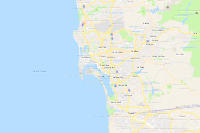

In [26]:
map_item = gis.content.search('title:San Diego, California owner:esri_nav', outside_org=True)[0]
map_item

2. From the apps module, import the Navigator URL builder function and then create a unique URL for each route result. Navigtor will open to the specified Map and Route Layer when the URL is opened. 

 - a. create `url_type` of 'Web' that can opened on iOS or Android devices from email, text message, etc.
 - b. set the`route_item` parameter from the route's `RouteLayerItemID` attribute
 - c. use the preferred map as the `webmap` parameter

In [27]:
from arcgis.apps import build_navigator_url

routes = routes_layer.query(out_fields="OBJECTID,RouteLayerItemID,RouteLayerItemURL,StopCount,TotalStopServiceTime,SHAPE")
for route in routes:
    route_layer_item_id = route.attributes['RouteLayerItemID']
    share_route_with_group(route_layer_item_id, "NavUsers Routes")
    url = build_navigator_url(url_type='Web',webmap=map_item, route_item=route_layer_item_id)
    print(url)

https://navigator.arcgis.app?itemID=da5fdb60b7854b2881f80e275bb802da&routeItemID=5c159a41df2e45bbba1ff1eab63ab95d
https://navigator.arcgis.app?itemID=da5fdb60b7854b2881f80e275bb802da&routeItemID=33fedfe358044efaa4de9bd97e51169b
https://navigator.arcgis.app?itemID=da5fdb60b7854b2881f80e275bb802da&routeItemID=4f5262a363e842deb05cc8da16fbf9a7
https://navigator.arcgis.app?itemID=da5fdb60b7854b2881f80e275bb802da&routeItemID=d114585300614613bb8f480bca3edded
